In [7]:
from os.path import join
import datetime
from os import listdir
from os import getcwd
from os.path import isfile, splitext
import numpy as np
import keras
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf



# a method to correct an incorrect directory structure for the keras imagedatagenerator
def correct_directory_structure(train_percent, test_percent, validation_percent, *dpaths): #dpaths: directories with classes of data
    import random
    from math import floor
    cwd = getcwd() + '\\'
    dir_list = listdir(cwd)
    #check that we are not overwriting directories train,test,validation
    assert not any (d in dir_list for d in ['train', 'test', 'validation']), 'cannot correct directory structure, as some files will be overwritten'
    assert all (d in dir_list for d in dpaths), 'the listed directories are not in the current path'
    
    [os.mkdir(f"{i}") for i in ['train','test','validation']]
    [os.mkdir(f"{i}\\{d}") for i in ['train','test','validation'] for d in dpaths]
        
    data_gen = ((d,listdir(d)) for d in dpaths)
    for d,i in data_gen:
        shuffled_files = random.sample(i,len(i))
        
        train_end = floor(len(shuffled_files)*train_percent)
        test_end = floor(train_end + (len(shuffled_files) - train_end)*test_percent/(test_percent + validation_percent))
        
        train_data = shuffled_files[0:train_end]
        test_data = shuffled_files[train_end:test_end]
        validation_data = shuffled_files[test_end:]
        
        for m in train_data:
            try:
                os.rename (f"{cwd}{d}\\{m}", f"{cwd}train\\{d}\\{m}")
            except:
                print ("hit and error, moving forward")
        for m in test_data:
            try:
                os.rename (f"{cwd}{d}\\{m}", f"{cwd}test\\{d}\\{m}")
            except:
                print ("hit and error, moving forward")
        for m in validation_data:
            try:
                os.rename (f"{cwd}{d}\\{m}", f"{cwd}validation\\{d}\\{m}")
            except:
                print ("hit and error, moving forward")
    
image_shape = (400,400,3)

# returns the iterators for data in directories so the model can be trained on batches of data without needing much RAM
def get_image_iterators(train_dir = 'train',
                        val_dir = 'validation',
                        test_dir = 'test',
                        mode = 'binary',
                        batch = 64,
                        size = image_shape[:2],
                        processing = None): 
    cwd = getcwd() + '\\'
    image_gen = ImageDataGenerator(
        rotation_range = 90,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 5,
        brightness_range = (0.7,1.),
        horizontal_flip = True,
        vertical_flip = True,
        preprocessing_function = processing
    )
    # these already shuffle the data
    train_set = image_gen.flow_from_directory(train_dir, class_mode = mode, batch_size = batch, target_size = size)
    val_set = image_gen.flow_from_directory(val_dir, class_mode = mode, batch_size = batch, target_size = size)
    test_set = image_gen.flow_from_directory(test_dir, class_mode = mode, batch_size = batch, target_size = size)
    return (train_set, val_set, test_set)

#correct_directory_structure(0.7,0.15,0.15, 'Bees', 'Not_Bees')

# for this function to work, the directory structure must be:
# train/
#    |
#    ├── class_1/
#    |       ├── image1.jpg
#    |       ├── image2.jpg
#    |       └── ...
#    |
#    ├── class_2/
#    |       ├── image1.jpg
#    |       ├── image2.jpg
#    |       └── ...
# test/
#    |
#    ├── class_1/
#    |       ├── image1.jpg
#    |       ├── image2.jpg
#    |       └── ...
#    |
#    ├── class_2/
#    |       ├── image1.jpg
#    |       ├── image2.jpg
#    |       └── ...
# ...

# my machine has enough RAM to handle 1000 images, but decrease it if you encounter problems
train,validation,test = get_image_iterators(batch = 32)

Found 20858 images belonging to 2 classes.
Found 4471 images belonging to 2 classes.
Found 4470 images belonging to 2 classes.


# Setting up Tensorboard

In [2]:
# setting up tensorboard for visualisation

%reload_ext tensorboard

log = join (getcwd(), "tflogs", "fit", datetime.datetime.now().strftime("%Y%m%d%H%M%S"))

tf_callback = tf.keras.callbacks.TensorBoard (log_dir=log, histogram_freq = 1)

# Making custom callbacks

In [15]:
class SaverCallback (tf.keras.callbacks.Callback):
    def __init__ (self, model, test_data, save_path, batch = 10): # test_data must be either a keras sequence or dataset
        self.best = test_data if type(test_data) == float else model.evaluate(test_data, callbacks = [self], batch_size = batch)[1] #init val accuracy 
        self.save_path = save_path
        self.model = model
    def on_epoch_end (self, epoch, logs = None):
        assert logs.get('val_accuracy') != None
        
        if self.best < logs['val_accuracy']:
            self.best = logs['val_accuracy']
            self.model.save(self.save_path)

class val_accuracy_recorder (keras.callbacks.Callback):
    def __init__ (self):
        self.accuracies = []
        self.best_accuracy = -np.inf
        self.train_accuracies = []
        self.avg_accuracies = []
    def on_epoch_end (self, epoch, logs=None):
        assert logs.get('val_accuracy') != None, 'no validation set for val_acc_recorder'
        self.train_accuracies.append(logs['val_accuracy'])
        if self.best_accuracy < logs['val_accuracy']:
            self.best_accuracy = logs['val_accuracy']
            
    def on_train_end (self, logs=None):
        self.accuracies.append(self.best_accuracy)
        # reset for next model training
        self.best_accuracy = -np.inf
        self.avg_accuracies.append(sum(self.train_accuracies)/len(self.train_accuracies))
        
            
        



# CNN

In [4]:
# run this if you don't have a model yet, else run the next cell
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=image_shape),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile (
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics= ['accuracy']
)


In [5]:
CNN_model_path = join(getcwd(), 'models', 'CNNmodel')
model = keras.models.load_model (CNN_model_path)

In [16]:
saver = SaverCallback(model, 0.892, CNN_model_path)

In [ ]:
model.fit(train, validation_data = validation, callbacks = [tf_callback, saver], epochs = 30, initial_epoch = 25, batch_size = 10) # remove initial epoch if this is the first time

Epoch 26/30
652/652 [==============================] - 676s 1s/step - loss: 0.3094 - accuracy: 0.8792 - val_loss: 0.2838 - val_accuracy: 0.8920
Epoch 27/30
652/652 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8845

In [25]:
model.evaluate (test)

70/70 [==============================] - 135s 2s/step - loss: 0.2888 - accuracy: 0.8879


[0.2887553870677948, 0.8879194855690002]

# PCA with CNN

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import stats
import matplotlib.image as mpimg

compression = 20
def compress_images(img):

        # Split into channels
        blue, green, red = cv2.split(img)

        # Scale the data between 0 and 1 for all channels
        r = red / 255
        b = blue / 255
        g = green / 255

        # Fit and transform data in PCA to reduce dimensionality
        red_pca = PCA(n_components=compression)
        red_pca.fit(r)
        red_trans = red_pca.transform(r)

        blue_pca = PCA(n_components=compression)
        blue_pca.fit(b)
        blue_trans = blue_pca.transform(b)

        green_pca = PCA(n_components=compression)
        green_pca.fit(g)
        green_trans = green_pca.transform(g)

        # Reconstruct the images
        r_arr = red_pca.inverse_transform(red_trans)
        b_arr = blue_pca.inverse_transform(blue_trans)
        g_arr = green_pca.inverse_transform(green_trans)

        # Merge channels into one
        compressed_image = (cv2.merge((b_arr, g_arr, r_arr)))
        return np.array(compressed_image)




In [23]:
modelPCA = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=image_shape),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

modelPCA.compile (
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics= ['accuracy']
)


In [33]:
train,validation,test = get_image_iterators(processing = compress_images)

modelPCA.fit(train, validation_data = validation, epochs = 10, callbacks = [tf_callback])

Found 20858 images belonging to 2 classes.
Found 4471 images belonging to 2 classes.
Found 4470 images belonging to 2 classes.
Epoch 1/10
326/326 [==============================] - 1629s 5s/step - loss: 0.7537 - accuracy: 0.7313 - val_loss: 0.5395 - val_accuracy: 0.7202
Epoch 2/10
326/326 [==============================] - 1655s 5s/step - loss: 0.4482 - accuracy: 0.8167 - val_loss: 0.4002 - val_accuracy: 0.8376
Epoch 3/10
326/326 [==============================] - 1618s 5s/step - loss: 0.3807 - accuracy: 0.8576 - val_loss: 0.3423 - val_accuracy: 0.8741
Epoch 4/10
326/326 [==============================] - 1581s 5s/step - loss: 0.3339 - accuracy: 0.8720 - val_loss: 0.3002 - val_accuracy: 0.8803
Epoch 5/10
326/326 [==============================] - 1597s 5s/step - loss: 0.2988 - accuracy: 0.8881 - val_loss: 0.2619 - val_accuracy: 0.8953
Epoch 6/10
326/326 [==============================] - 1566s 5s/step - loss: 0.2749 - accuracy: 0.8929 - val_loss: 0.2525 - val_accuracy: 0.9038
Epoch 7/1

# Testing trend for increasing compression with limited data set

In [28]:
train,validation,test = get_image_iterators(processing = compress_images)

Found 20858 images belonging to 2 classes.
Found 4471 images belonging to 2 classes.
Found 4470 images belonging to 2 classes.


In [29]:
#making a fold left function
from functools import reduce
stack_features_and_labels = lambda fl1, fl2: (np.vstack((fl1[0], fl2[0])), np.hstack((fl1[1], fl2[1])))

# take some data and load it into ram so it's fast to train with it
def limit_data (data, included_batches): # requires an iterator
    holder = next(data)
    for i in range (1, included_batches):
        holder = stack_features_and_labels (holder, next(data))
    return holder

In [40]:
limited_train_data = limit_data(train,1)
limited_test_data = limit_data(test,1)
limited_validation_data = limit_data(validation,1)

In [41]:
limited_test_data = tf.data.Dataset.from_tensor_slices (limited_test_data)
limited_test_data = limited_test_data.batch(32)

In [54]:
trend_tester_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=image_shape),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

trend_tester_model.compile (
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics= ['accuracy']
) 

# but before we begin... let's save the weights and reset them after every training session
weights_path = join(getcwd(), 'trend_tester_weights')
trend_tester_model.save_weights (weights_path)
validation_accuracies = val_accuracy_recorder()

for i in range (40, 0, -1):
    compression = i
    trend_tester_model.load_weights (weights_path)
    trend_tester_model.fit(limited_train_data[0],
                           limited_train_data[1],
                           validation_data = limited_validation_data ,
                           batch_size= 10,
                           epochs = 10,
                          callbacks = [validation_accuracies, saver],
                          verbose = 0)



2/2 [==============================] - 0s 39ms/step - loss: 0.6754 - accuracy: 0.6719


INFO:tensorflow:Assets written to: idunno\assets


INFO:tensorflow:Assets written to: idunno\assets


model saved: False


INFO:tensorflow:Assets written to: idunno\assets


INFO:tensorflow:Assets written to: idunno\assets


model saved: False


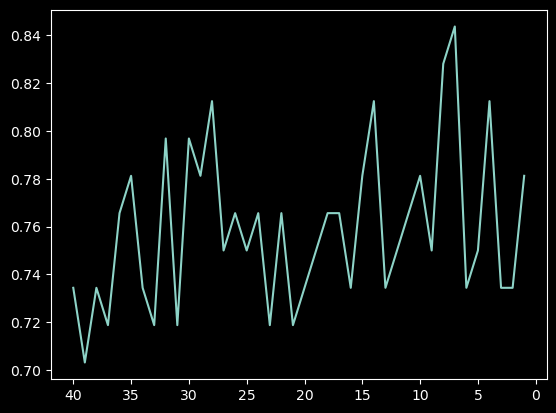

In [22]:

x = range(40,0,-1)
y = validation_accuracies.accuracies

plt.style.use('dark_background')
ax = plt.subplot()
ax.plot (x,y)
ax.invert_xaxis()

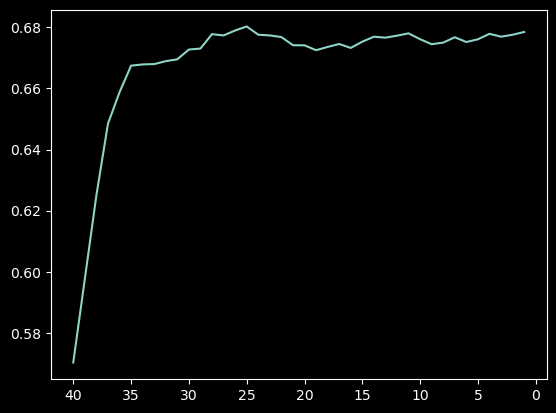

In [24]:
y = validation_accuracies.avg_accuracies
ax = plt.subplot()
ax.plot (x,y)
ax.invert_xaxis()